In [ ]:
#https://strengejacke.github.io/ggeffects/reference/ggpredict.html


In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')



## Load model parameters and mobility_heat

In [143]:
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'




In [144]:
df = pd.read_csv("/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/regression/params_clean_final_90_v1.csv")
df.columns = ['variable', 'estimate']

#final2 is 4C 

mob_vars = pd.read_csv("/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/mobility_heat/final_multivariate_clean_90_v1.csv")


In [145]:
mob_vars['stage_frac'] = mob_vars['stage_frac'] / 100

In [146]:
mob_vars['temperature_2m_heat'].mean()

33.392870965862436

In [147]:
mob_vars['heat_temp'] = mob_vars['heat_temp_centered'] + 33




In [148]:

#mob_vars['temperature_2m_winter'] = mob_vars['temperature_2m_winter'] - 4




In [149]:
mob_vars['temp_diff']




0       12.976720
1        2.771871
2        4.784609
3        3.849402
4        7.335590
          ...    
6081    11.452108
6082     4.438159
6083    10.211491
6084    10.950739
6085    11.969346
Name: temp_diff, Length: 6086, dtype: float64

#### format variables for every year (as opposed to categorical), format binary variable for duration and coast

In [150]:
mob_vars['2020'] = [1 if x==2020 else 0 for x in mob_vars['year']]
mob_vars['2021'] = [1 if x==2021 else 0 for x in mob_vars['year']]
mob_vars['2022'] = [1 if x==2022 else 0 for x in mob_vars['year']]
mob_vars['hw_dur'] = [1 if x=='>5 days' else 0 for x in mob_vars['heatwave_dur']]
mob_vars['coast_binary'] = mob_vars['coast_binary']* 1





### slice parameters for every dependent variable

In [151]:
df['workplaces'] = [1 if 'workplaces' in x else 0 for x in df['variable'] ]
df['residential'] = [1 if 'residential' in x else 0 for x in df['variable'] ]
df['grocery_pharmacy'] = [1 if 'grocery_pharmacy' in x else 0 for x in df['variable'] ]
df['parks'] = [1 if 'parks' in x else 0 for x in df['variable'] ]
df['retail'] = [1 if 'retail' in x else 0 for x in df['variable'] ]
df['transit'] = [1 if 'transit' in x else 0 for x in df['variable'] ]




In [152]:
residential = df[df['residential'] == 1].reset_index()
workplaces = df[df['workplaces'] == 1].reset_index()
grocery_pharmacy = df[df['grocery_pharmacy'] == 1].reset_index()
parks = df[df['parks'] == 1].reset_index()
retail = df[df['retail'] == 1].reset_index()
transit = df[df['transit'] == 1].reset_index()



### Format params into dataframe

In [153]:
dic = {}
for response in ['workplaces', 'residential', 'grocery_pharmacy', 'parks', 'retail', 'transit']:
    
    dic[response] = {}
    subset = df[df[response]==1].reset_index()
    dic[response]['global_intercept'] = subset.iloc[0, 2]
    dic[response]['heat_temp_centered_California'] = subset.iloc[1,2]
    dic[response]['British Columbia_intercept'] = subset.iloc[2,2]
    dic[response]['Oregon_intercept'] = subset.iloc[3,2]
    dic[response]['Washington_intercept'] = subset.iloc[4,2]
    dic[response]['heat_temp_centered_British Columbia'] = subset.iloc[5,2]
    dic[response]['heat_temp_centered_Oregon'] = subset.iloc[6,2]
    dic[response]['heat_temp_centered_Washington'] = subset.iloc[7,2]
    dic[response]['temp_diff'] = subset.iloc[8,2]
    dic[response]['stage_frac'] = subset.iloc[9,2]
    dic[response]['weekend'] = subset.iloc[10,2]
    dic[response]['year2021'] = subset.iloc[11,2]
    dic[response]['year2022'] = subset.iloc[12,2]
    dic[response]['hw_duration'] = subset.iloc[13,2]
    dic[response]['june_hw'] = subset.iloc[14,2]
    dic[response]['coast_binary'] = subset.iloc[15,2]
    dic[response]['temperature_2m_winter_British Columbia'] = subset.iloc[16,2]
    dic[response]['temperature_2m_winter_Oregon'] = subset.iloc[17,2]
    dic[response]['temperature_2m_winter_Washington'] = subset.iloc[18,2]
    dic[response]['popdens_dec'] = subset.iloc[19,2]
    dic[response]['income_dec'] = subset.iloc[20,2]
    dic[response]['over65_dec'] = subset.iloc[21,2]
    dic[response]['nonwhite_dec'] = subset.iloc[22,2]

### Create function which fixes all other variables for marginal effects calculation
* Gets the mean of each variable in the dataset, multiplies it by the corresponding parameter

In [154]:
dic['parks']

{'global_intercept': 10.4034969774607,
 'heat_temp_centered_California': -1.49678934405208,
 'British Columbia_intercept': 18.0865831954914,
 'Oregon_intercept': -1.19978139546536,
 'Washington_intercept': 5.41905808506419,
 'heat_temp_centered_British Columbia': 0.545507077260617,
 'heat_temp_centered_Oregon': -0.0274172913102758,
 'heat_temp_centered_Washington': 0.124722789746271,
 'temp_diff': 2.15557598077076,
 'stage_frac': -10.6399107427586,
 'weekend': 7.25775928802311,
 'year2021': -6.62100485916909,
 'year2022': -1.93860202942918,
 'hw_duration': -6.76119195572823,
 'june_hw': 3.44093396603711,
 'coast_binary': 11.1968347251384,
 'temperature_2m_winter_British Columbia': -1.28892729386657,
 'temperature_2m_winter_Oregon': 0.395877854669203,
 'temperature_2m_winter_Washington': 2.24899389251521,
 'popdens_dec': -1.51435753720195,
 'income_dec': -0.836074998380087,
 'over65_dec': -0.853816725881402,
 'nonwhite_dec': -0.39662215643397}

In [155]:
def get_average_effects(dic, response, state):
    
    
    estimate_subset = dic[response]
    
    global_int = estimate_subset['global_intercept']
    
    #get each state's unique subset (average covariates are unique to each state)
    mob_vars_subset = mob_vars


    
    
    variable_sum = sum([estimate_subset['temp_diff']*mob_vars_subset['temp_diff'].mean(), 
                  estimate_subset['stage_frac']*mob_vars_subset['stage_frac'].mean(), 
                  estimate_subset['weekend']*mob_vars_subset['weekend'].mean(), 
                  estimate_subset['year2021']*mob_vars_subset.groupby('heat_ID')['2021'].mean().mean(),
                  estimate_subset['year2022']*mob_vars_subset.groupby('heat_ID')['2022'].mean().mean(), 
                  estimate_subset['hw_duration']*mob_vars_subset.groupby('heat_ID')['hw_dur'].mean().mean(), 
                  estimate_subset['june_hw']*mob_vars_subset.groupby('heat_ID')['june_hw'].mean().mean(), 
                  estimate_subset['coast_binary']*mob_vars_subset.groupby('location')['coast_binary'].mean().mean(),
                  estimate_subset['popdens_dec']*mob_vars_subset.groupby('location')['popdens_dec'].mean().mean(), 
                  estimate_subset['over65_dec']*mob_vars_subset.groupby('location')['over65_dec'].mean().mean(),
                  estimate_subset['income_dec']*mob_vars_subset.groupby('location')['income_dec'].mean().mean(), 
                  estimate_subset['nonwhite_dec']*mob_vars_subset.groupby('location')['nonwhite_dec'].mean().mean()])
        

    

    #average out total winter effect with global mean (this is unique because it is a bias in the data, we do not want 
    # to use it to parse out state-level differences, we want to negate its influence)
    if state != 'California':
    
        slope = estimate_subset[f'heat_temp_centered_{state}'] + estimate_subset[f'heat_temp_centered_California']
        winter_temp_shift = estimate_subset[f'temperature_2m_winter_{state}']*0
        variable_sum += winter_temp_shift
        final_average = global_int + variable_sum + estimate_subset[f'{state}_intercept']
        print(state, response)

    else: 
        
        slope = estimate_subset[f'heat_temp_centered_California']
        final_average = global_int + variable_sum 
    
    params_dic = {}
        
    return [slope, final_average]




## Iterate through repsonses and states, create dictionary with intercepts and slopes

In [156]:
params_dic = {}
for response in ['workplaces', 'residential', 'grocery_pharmacy', 'retail', 'parks','transit' ]:
    params_dic[response] = {}
    for state in ['British Columbia', 'Washington', 'Oregon', 'California']:
        params_dic[response][state] = get_average_effects(dic, response, state)


British Columbia workplaces
Washington workplaces
Oregon workplaces
British Columbia residential
Washington residential
Oregon residential
British Columbia grocery_pharmacy
Washington grocery_pharmacy
Oregon grocery_pharmacy
British Columbia retail
Washington retail
Oregon retail
British Columbia parks
Washington parks
Oregon parks
British Columbia transit
Washington transit
Oregon transit


In [157]:
def plot_regression(response, params_dic):
    bc_line = np.poly1d(params_dic[response]['British Columbia'])
    wa_line = np.poly1d(params_dic[response]['Washington'])
    or_line = np.poly1d(params_dic[response]['Oregon'])
    ca_line = np.poly1d(params_dic[response]['California'])
    
    x_axis = np.linspace(-10,10,20)
    bc_y_axis = bc_line(x_axis)
    wa_y_axis = wa_line(x_axis)
    or_y_axis = or_line(x_axis)
    ca_y_axis = ca_line(x_axis)
    x_axis += 34
    BC_temp = mob_vars[mob_vars['state'] == "British Columbia"]['heat_temp'].mean()
    WA_temp = mob_vars[mob_vars['state'] == "Washington"]['heat_temp'].mean()
    OR_temp = mob_vars[mob_vars['state'] == "Oregon"]['heat_temp'].mean()
    CA_temp = mob_vars[mob_vars['state'] == "California"]['heat_temp'].mean()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    pos = ax.get_position()
    
    
    min_y = np.concatenate([bc_y_axis, wa_y_axis, or_y_axis, ca_y_axis]).min() 
    max_y = np.concatenate([bc_y_axis, wa_y_axis, or_y_axis, ca_y_axis]).max() 


    sns.lineplot(x=x_axis, y=bc_y_axis, ax =ax, label='BC', color='purple')
    sns.lineplot(x=x_axis, y=wa_y_axis, ax =ax, label='WA', color='green')
    sns.lineplot(x=x_axis, y=or_y_axis, ax =ax, label='OR', color='orange')
    sns.lineplot(x=x_axis, y=ca_y_axis, ax =ax, label='CA', color='red')
    
    
    plt.vlines(x=BC_temp, ymin=min_y, ymax=max_y, colors='purple', ls='--', lw=1, label='BC mean heatwave')
    plt.vlines(x=WA_temp, ymin=min_y, ymax=max_y, colors='green', ls='--', lw=1, label='WA mean heatwave')
    plt.vlines(x=OR_temp, ymin=min_y, ymax=max_y, colors='orange', ls='--', lw=1, label='OR mean heatwave')
    plt.vlines(x=CA_temp, ymin=min_y, ymax=max_y, colors='red', ls='--', lw=1, label='CA mean heatwave')
    
    plt.title(f"Percent change in {response} activity with heat wave temperature")
    plt.xlabel(f"Heat wave temperature (C)")
    plt.ylabel(f"Percent change in mobility")
    plt.tight_layout()
    #ax.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height])
    plt.legend()
    #plt.savefig(data_path + f'imgs/state_regression_plots/{response}_v8.png', dpi=400)


    plt.show()

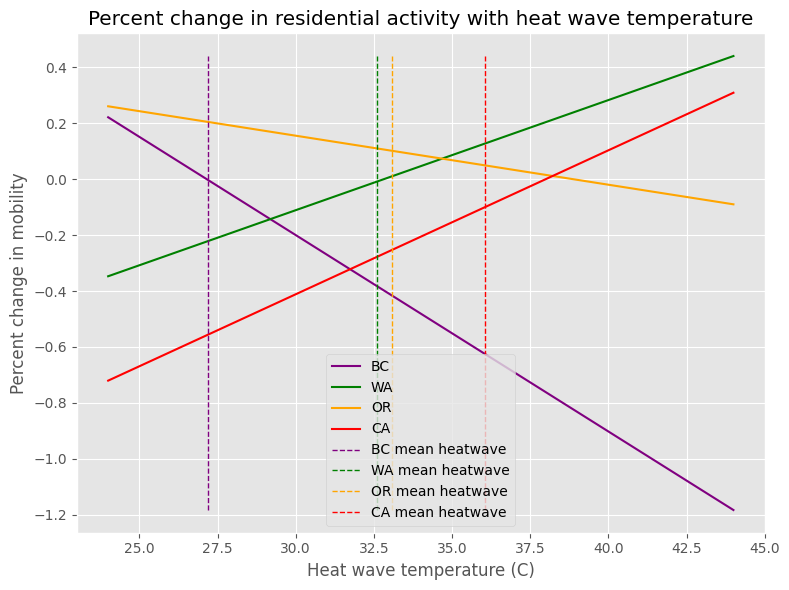

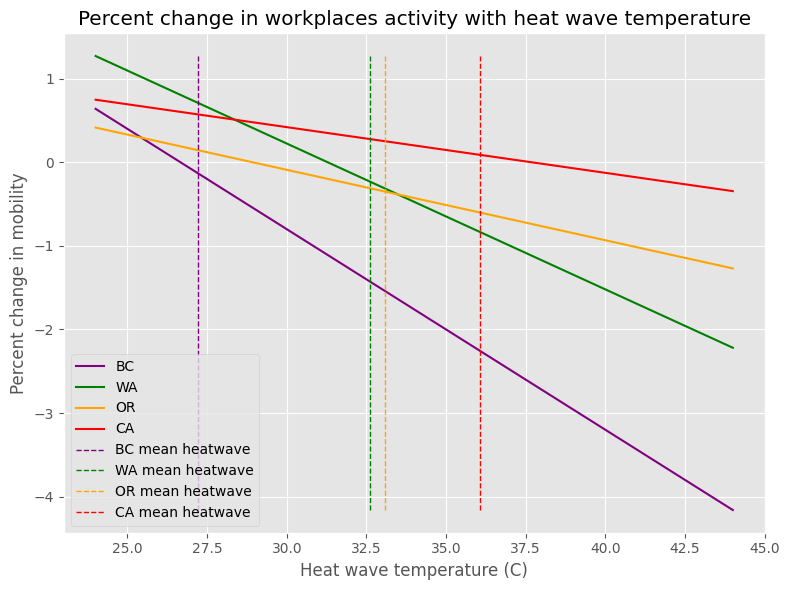

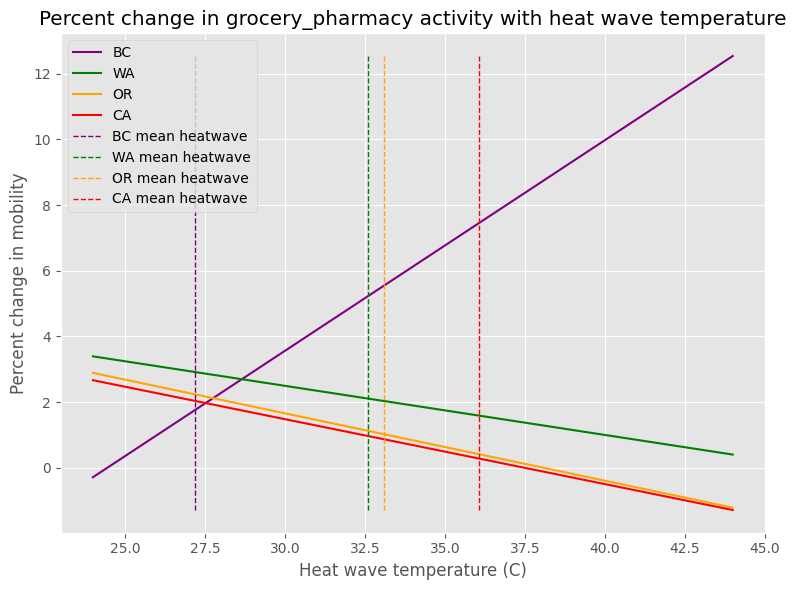

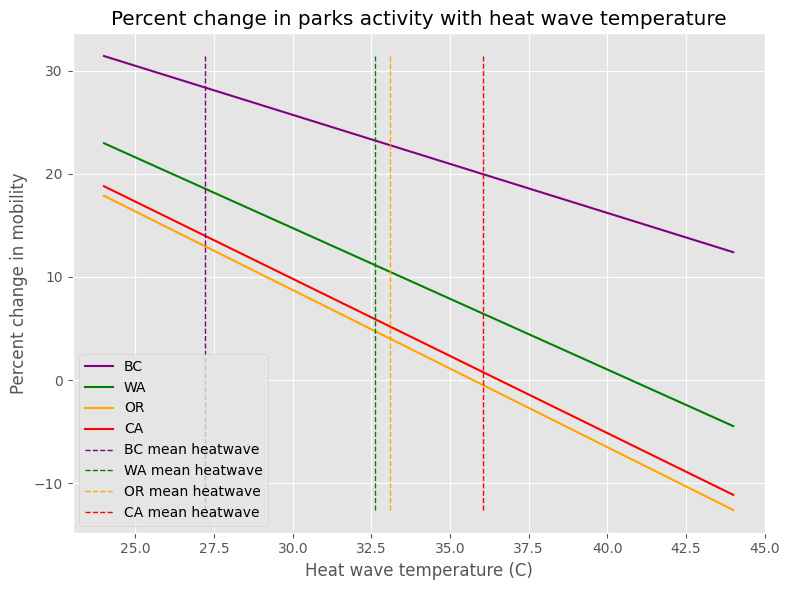

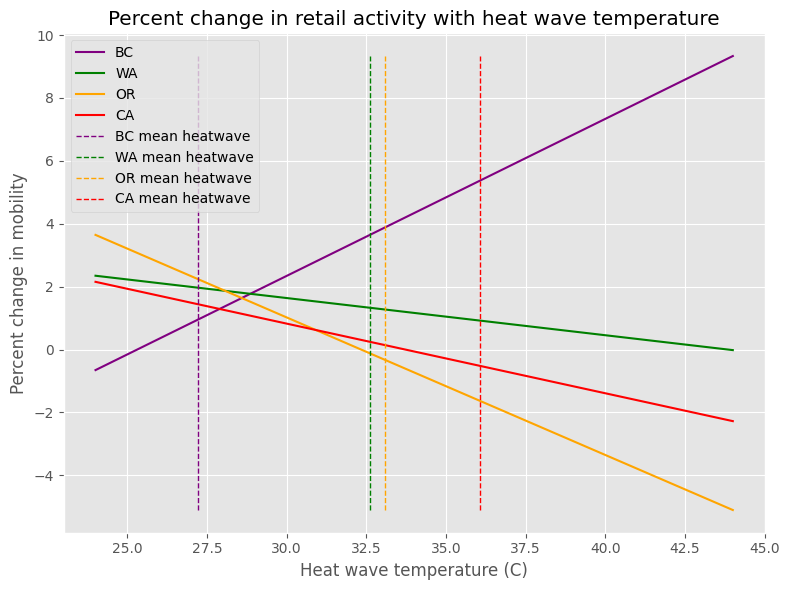

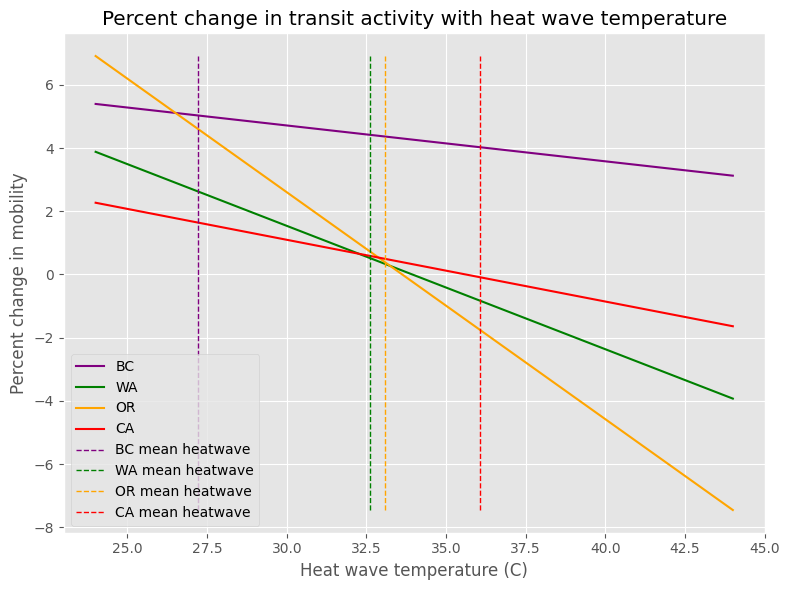

In [158]:
plot_regression('residential', params_dic)
plot_regression('workplaces', params_dic)
plot_regression('grocery_pharmacy', params_dic)
plot_regression('parks', params_dic)
plot_regression('retail', params_dic)
plot_regression('transit', params_dic)


### Create function which plots marginal effects for each state

In [159]:
master = pd.DataFrame()
for response in ['residential', 'workplaces', 'transit', 'grocery_pharmacy', 'retail', 'parks']:
    
    bc_line = np.poly1d(params_dic[response]['British Columbia'])
    wa_line = np.poly1d(params_dic[response]['Washington'])
    or_line = np.poly1d(params_dic[response]['Oregon'])
    ca_line = np.poly1d(params_dic[response]['California'])
    
    x_axis = np.linspace(-10,10,20)
    bc_y_axis = bc_line(x_axis)
    wa_y_axis = wa_line(x_axis)
    or_y_axis = or_line(x_axis)
    ca_y_axis = ca_line(x_axis)
    
    bc = pd.DataFrame(x_axis, bc_y_axis)
    wa = pd.DataFrame(x_axis, wa_y_axis) 
    ore = pd.DataFrame(x_axis, or_y_axis)
    ca = pd.DataFrame(x_axis, ca_y_axis)
    
    bc['state'] = 'British Columbia'
    wa['state'] = 'Washington'
    ore['state'] = 'Oregon'
    ca['state'] = 'California'
    
    bc.reset_index(inplace=True)
    wa.reset_index(inplace=True)
    ore.reset_index(inplace=True)
    ca.reset_index(inplace=True)
    
    df = pd.concat([bc, wa, ore, ca])
    df['response'] = response
    
    master = master.append(df)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_4264/1988237988.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master = master.append(df)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_4264/1988237988.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master = master.append(df)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_4264/1988237988.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master = master.append(df)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_4264/1988237988.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master = master.append(df)
/var/folders/8g/qp1k_1g9

In [160]:
master.columns = ['change', 'temp', 'state', 'response']

In [161]:
master['temp'] += 33

In [162]:
master

,change,temp,state,response
0,0.221605,23.000000,British Columbia,residential
1,0.147645,24.052632,British Columbia,residential
2,0.073685,25.105263,British Columbia,residential
3,-0.000274,26.157895,British Columbia,residential
4,-0.074234,27.210526,British Columbia,residential
...,...,...,...,...
15,-4.833318,38.789474,California,parks
16,-6.408886,39.842105,California,parks
17,-7.984454,40.894737,California,parks
18,-9.560021,41.947368,California,parks


In [163]:
master.to_csv(data_path + 'results/reg_plots/data_v4.csv')

In [164]:
bc = pd.DataFrame(x_axis, bc_y_axis)
wa = pd.DataFrame(x_axis, wa_y_axis) 
ore = pd.DataFrame(x_axis, or_y_axis)
ca = pd.DataFrame(x_axis, ca_y_axis)

In [165]:
bc['state'] = 'British Columbia'
wa['state'] = 'Washington'
ore['state'] = 'Oregon'
ca['state'] = 'California'

In [140]:
bc.reset_index(inplace=True)
wa.reset_index(inplace=True)
ore.reset_index(inplace=True)
ca.reset_index(inplace=True)

In [141]:
pd.concat([bc, wa, ore, ca])

,index,0,state
0,31.431710,-10.000000,British Columbia
1,30.430361,-8.947368,British Columbia
2,29.429011,-7.894737,British Columbia
3,28.427661,-6.842105,British Columbia
4,27.426311,-5.789474,British Columbia
...,...,...,...
15,-4.833318,5.789474,California
16,-6.408886,6.842105,California
17,-7.984454,7.894737,California
18,-9.560021,8.947368,California


In [21]:

x_axis = np.linspace(-10,10,20)

In [27]:
pd.DataFrame(x_axis, bc_y_axis, ca_y_axis)

,0
1.893137,-10.000000
1.695366,-8.947368
1.497594,-7.894737
1.299823,-6.842105
1.102052,-5.789474
0.904281,-4.736842
0.706509,-3.684211
0.508738,-2.631579
0.310967,-1.578947
0.113195,-0.526316


In [22]:
ca_y_axis = ca_line(x_axis)

In [23]:
ca_y_axis

array([ 1.89313711,  1.69536579,  1.49759447,  1.29982316,  1.10205184,
        0.90428052,  0.7065092 ,  0.50873788,  0.31096656,  0.11319525,
       -0.08457607, -0.28234739, -0.48011871, -0.67789003, -0.87566134,
       -1.07343266, -1.27120398, -1.4689753 , -1.66674662, -1.86451794])

In [ ]:
BC_average + dic['BC_intercept']

NameError: name 'BC_average' is not defined

In [ ]:
BC

(-5.27530945013604, -0.2907304730025854)

In [75]:
df.iloc[8, 1]*mob_vars['temp_diff'].mean() + \
df.iloc[9, 1]*mob_vars['stage_frac'].mean() + df.iloc[10, 1]*mob_vars['weekend'].mean() + df.iloc[11, 1]*mob_vars['2021'].mean() + df.iloc[12, 1]*mob_vars['2021'].mean() \
+ df.iloc[13, 1]*mob_vars['hw_dur'].mean() + df.iloc[14, 1]*mob_vars['first_annual_hw'].mean() + df.iloc[15, 1]*mob_vars['coast_binary'].mean() + df.iloc[16, 1]*mob_vars['temperature_2m_winter'].mean() \
+ df.iloc[17, 1]*mob_vars['income_dec'].mean()  + df.iloc[13, 1]*mob_vars['over65_dec'].mean()

0.5994009767020654

In [65]:
def get_state_intercept(dic, mob_vars):
    

In [52]:
BC_intercept = df.iloc[0, 1] + df.iloc[1, 1]*0 + df.iloc[2, 1] * 1 + df.iloc[5, 1] * 0 + df.iloc[8, 1]*mob_vars['temp_diff'].mean() + \
df.iloc[9, 1]*mob_vars['stage_frac'].mean() + df.iloc[10, 1]*mob_vars['weekend'].mean() + df.iloc[11, 1]*mob_vars['2021'].mean() + df.iloc[12, 1]*mob_vars['2021'].mean() \
+ df.iloc[13, 1]*mob_vars['hw_dur'].mean() + df.iloc[14, 1]*mob_vars['first_annual_hw'].mean() + df.iloc[15, 1]*mob_vars['coast_binary'].mean() + df.iloc[16, 1]*mob_vars['temperature_2m_winter'].mean() \
+ df.iloc[17, 1]*mob_vars['income_dec'].mean()  + df.iloc[13, 1]*mob_vars['over65_dec'].mean()

In [54]:
CA_intercept = df.iloc[0, 1] + df.iloc[1, 1]*0 + df.iloc[3, 1] + df.iloc[5, 1] * 0 + df.iloc[8, 1]*mob_vars['temp_diff'].mean() + \
df.iloc[9, 1]*mob_vars['stage_frac'].mean() + df.iloc[10, 1]*mob_vars['weekend'].mean() + df.iloc[11, 1]*mob_vars['2021'].mean() + df.iloc[12, 1]*mob_vars['2021'].mean() \
+ df.iloc[13, 1]*mob_vars['hw_dur'].mean() + df.iloc[14, 1]*mob_vars['first_annual_hw'].mean() + df.iloc[15, 1]*mob_vars['coast_binary'].mean() + df.iloc[16, 1]*mob_vars['temperature_2m_winter'].mean() \
+ df.iloc[17, 1]*mob_vars['income_dec'].mean()  + df.iloc[13, 1]*mob_vars['over65_dec'].mean()

In [56]:
CA_intercept

-1.4249643783805825

In [34]:
mob_vars['heatwave_dur']

0       <5 days
1       <5 days
2       <5 days
3       <5 days
4       >5 days
         ...   
6209    <5 days
6210    <5 days
6211    <5 days
6212    <5 days
6213    <5 days
Name: heatwave_dur, Length: 6214, dtype: object

In [23]:
BC_intercept

3.1411658650496674

In [14]:
equation

-0.357955492423928

In [943]:
mob_vars

,Unnamed: 0,location,first_annual_hw,heat_ID,workplaces_difference,residential_difference,grocery_pharmacy_difference,retail_difference,parks_difference,transit_difference,...,temp_diff,heat_temp_centered,coast_binary,temperature_2m_winter,income_dec,over65_dec,2020,2021,2022,hw_dur
0,0,"Alameda County, California",1,d7b448e7-084c-4bfa-a5dc-2c2f7805665b,2.0,-1.0,1.0,-1.0,-6.0,2.0,...,13.428375,-1.950484,False,6.314208,10,3,1,0,0,0
1,1,"Alameda County, California",1,d7b448e7-084c-4bfa-a5dc-2c2f7805665b,3.0,-1.0,0.0,-1.0,-3.0,1.0,...,9.585419,-2.008040,False,6.314208,10,3,1,0,0,0
2,2,"Alameda County, California",0,27329488-1855-444f-be5f-e849a8a37970,15.0,-1.0,7.0,14.0,8.0,5.0,...,3.115372,-2.898635,False,6.314208,10,3,1,0,0,0
3,3,"Alameda County, California",0,27329488-1855-444f-be5f-e849a8a37970,2.0,1.0,8.0,4.0,12.0,1.0,...,3.685379,-2.488631,False,6.314208,10,3,1,0,0,0
4,4,"Alameda County, California",0,a1ebcf14-5a2d-4c10-9539-c0a87d613f14,-1.0,0.0,1.0,0.0,-10.0,-2.0,...,8.565338,0.743211,False,6.314208,10,3,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,2213,"Thompson-Nicola, British Columbia",0,d9c7e699-b7b8-47f2-910c-9999ef7ba5e7,1.0,-1.0,-6.0,-6.0,5.0,-6.0,...,8.750839,-6.292677,False,-9.490944,6,5,0,0,1,0
2214,2214,"Thompson-Nicola, British Columbia",0,15ca0559-a0da-49fe-bea4-d949221549cf,1.0,1.0,1.0,1.0,54.0,1.0,...,11.081390,-3.962126,False,-9.490944,6,5,0,0,1,0
2215,2215,"Thompson-Nicola, British Columbia",0,15ca0559-a0da-49fe-bea4-d949221549cf,0.0,2.0,4.0,0.0,-2.0,4.0,...,13.134964,-5.270125,False,-9.490944,6,5,0,0,1,0
2216,2216,"Thompson-Nicola, British Columbia",0,41652cae-d8c2-48f9-b1ea-9109e1660e8a,-3.0,-1.0,1.0,3.0,2.0,12.0,...,13.800476,-4.604613,False,-9.490944,6,5,0,0,1,0


In [950]:
df= df.drop('Unnamed: 0', axis=1)

In [956]:
df

,x
0,-7.506034
1,-6.667594
2,-2.200262
3,-5.303983
4,-6.547992
...,...
2213,-16.535965
2214,-15.852851
2215,-4.135679
2216,-3.160349


In [957]:
df = df.merge(mob_vars, left_index=True, right_index=True)

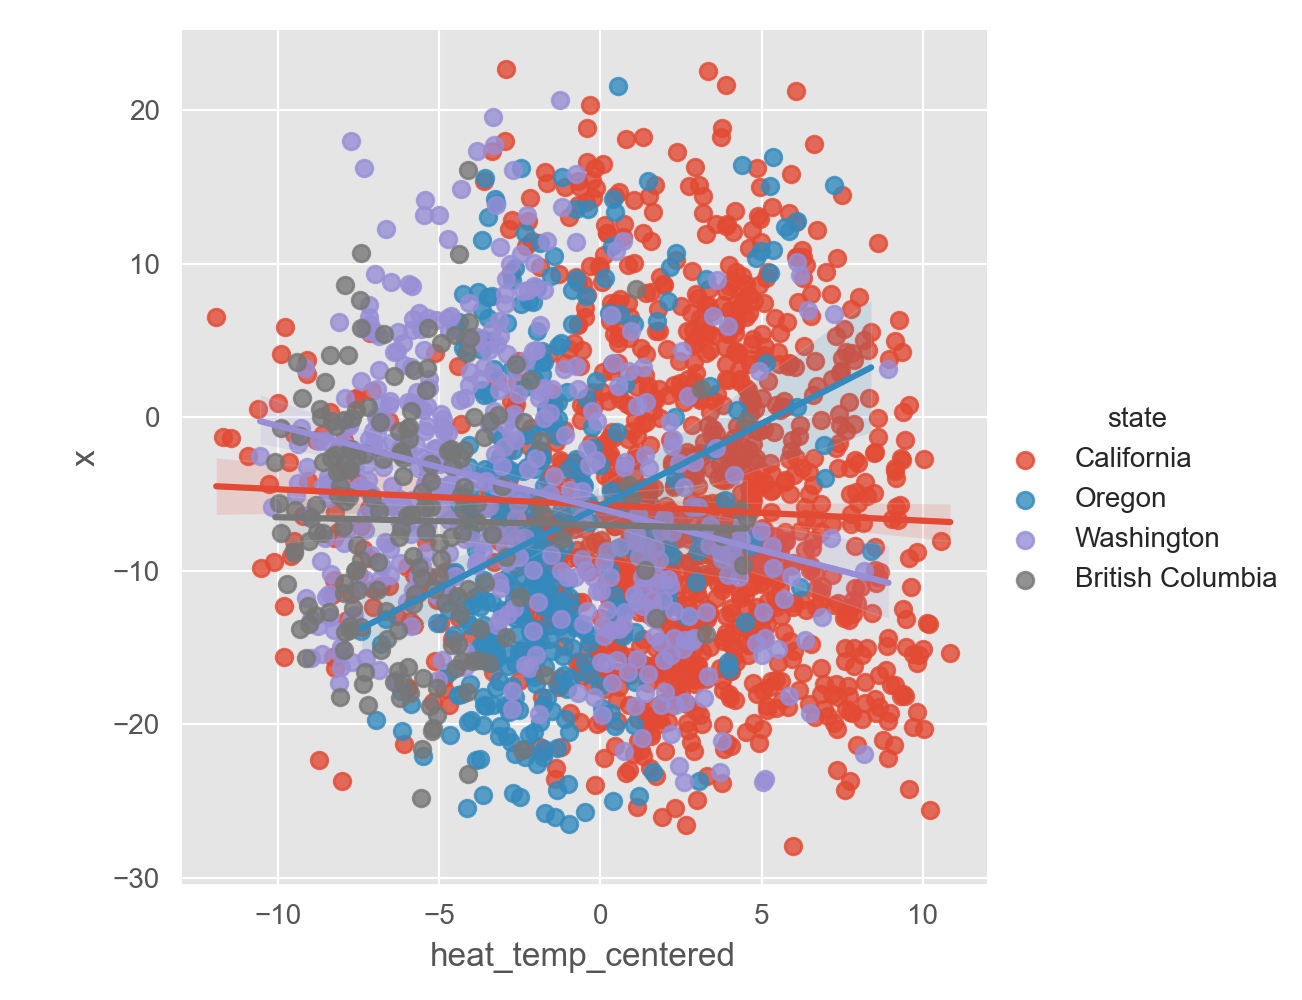

In [973]:
sns.lmplot(df, x='heat_temp_centered', y='x', hue='state')

In [3012]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3013]:
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

In [3014]:
df = pd.read_csv("/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/regression/multivariate_test_v12.csv")

In [3015]:
df.columns = ['variable', 'estimate']

In [3016]:
mob_vars = pd.read_csv(data_path + 'mobility_heat/mobility_heat_w_vars_parks_v24.csv')
mob_vars['2020'] = [1 if x==2020 else 0 for x in mob_vars['year']]
mob_vars['2021'] = [1 if x==2021 else 0 for x in mob_vars['year']]
mob_vars['2022'] = [1 if x==2022 else 0 for x in mob_vars['year']]
mob_vars['hw_dur'] = [1 if x=='>5 days' else 0 for x in mob_vars['heatwave_dur']]
mob_vars['coast_binary'] = mob_vars['coast_binary']* 1

In [3017]:
dic = {}
   
dic['global_intercept'] = df.iloc[0, 1]
dic['heat_temp_centered_California'] = df.iloc[1,1]
dic['British Columbia_intercept'] = df.iloc[2,1]
dic['Oregon_intercept'] = df.iloc[3,1]
dic['Washington_intercept'] = df.iloc[4,1]
dic['heat_temp_centered_British Columbia'] = df.iloc[5,1]
dic['heat_temp_centered_Oregon'] = df.iloc[6,1]
dic['heat_temp_centered_Washington'] = df.iloc[7,1]
dic['temp_diff'] = df.iloc[8,1]
dic['stage_frac'] = df.iloc[9,1]
dic['weekend'] = df.iloc[10,1]
dic['year2021'] = df.iloc[11,1]
dic['year2022'] = df.iloc[12,1]
dic['hw_duration'] = df.iloc[13,1]
dic['first_annual_hw'] = df.iloc[14,1]
dic['coast_binary'] = df.iloc[15,1]
dic['temperature_2m_winter'] = df.iloc[16,1]
dic['income_dec'] = df.iloc[17,1]
dic['over65_dec'] = df.iloc[18,1]

In [3018]:
*            stage_frac =   62.20
*            income_dec =    6.60
*             temp_diff =    8.12
*               weekend =       0
*          heatwave_dur = <5 days
*                  year =    2020
*       first_annual_hw =       0
*          coast_binary =   False
*            over65_dec =    4.37
* temperature_2m_winter =    2.26
*               heat_ID = 0 (population-level)
*              location = 0 (population-level)

SyntaxError: invalid syntax (2130676588.py, line 5)

In [3019]:
mob_vars_subset = mob_vars[mob_vars['parks_difference'].notnull()] 

In [3020]:
mob_vars_subset['temperature_2m_winter'].mean()

62.195640616693254

In [3086]:
def get_average_effects(dic, state):
    
    
    mob_vars_subset = mob_vars[mob_vars['parks_difference'].notnull()]    
    
    estimate_subset = dic
    
    global_int = estimate_subset['global_intercept']
    
    variable_sum = sum([estimate_subset['temp_diff']*mob_vars_subset['temp_diff'].mean(), 
                  estimate_subset['stage_frac']*mob_vars_subset['stage_frac'].mean(), 
                  estimate_subset['weekend']*mob_vars_subset['weekend'].mode()[0], 
                  #estimate_subset['year2021']*mob_vars_subset['2021'].mean(),
                  #estimate_subset['year2022']*mob_vars_subset['2022'].mean(), 
                  #estimate_subset['hw_duration']*mob_vars_subset['hw_dur'].mode()[0], 
                  estimate_subset['first_annual_hw']*mob_vars_subset['first_annual_hw'].mode()[0], 
                  estimate_subset['coast_binary']*mob_vars_subset['coast_binary'].mode()[0] , 
                  estimate_subset['temperature_2m_winter']*mob_vars_subset['temperature_2m_winter'].mean(), 
                  estimate_subset['income_dec']*mob_vars_subset['income_dec'].mean(), 
                  estimate_subset['over65_dec']*mob_vars_subset['over65_dec'].mean()])

    print(variable_sum)

    if state != 'California':
    
        slope = estimate_subset[f'heat_temp_centered_{state}'] + estimate_subset[f'heat_temp_centered_California']
        final_average = global_int +  estimate_subset[f'{state}_intercept']  +  variable_sum
    
        
    else: 
        
        slope = estimate_subset[f'heat_temp_centered_California']
        final_average = global_int + variable_sum #+ heat_shift
        
        
    return [slope, final_average]

In [3087]:
params_dic = {}
for response in ['parks']:
    params_dic[response] = {}
    for state in ['British Columbia', 'Washington', 'Oregon', 'California']:
        params_dic[response][state] = get_average_effects(dic, state)
        #print(response, state, params_dic[response][state])

3.5740385639541987
3.5740385639541987
3.5740385639541987
3.5740385639541987


In [3088]:
x_axis = np.linspace(-10,10,20)

In [3089]:
params_dic['parks']['British Columbia']

[-0.03476097675957002, 10.652981743585329]

In [3090]:
bc_line = np.poly1d(params_dic['parks']['British Columbia'])
wa_line = np.poly1d(params_dic['parks']['Washington'])
or_line = np.poly1d(params_dic['parks']['Oregon'])
ca_line = np.poly1d(params_dic['parks']['California'])

In [3091]:
x_axis = np.linspace(-15,15,20)
bc_y_axis = bc_line(x_axis)
wa_y_axis = wa_line(x_axis)
or_y_axis = or_line(x_axis)
ca_y_axis = ca_line(x_axis)

In [3092]:
plt.style.use('ggplot')
pos = ax.get_position()

In [3093]:
BC_temp = mob_vars[mob_vars['state'] == "British Columbia"]['heat_temp_centered'].mean()
WA_temp = mob_vars[mob_vars['state'] == "Washington"]['heat_temp_centered'].mean()
OR_temp = mob_vars[mob_vars['state'] == "Oregon"]['heat_temp_centered'].mean()
CA_temp = mob_vars[mob_vars['state'] == "California"]['heat_temp_centered'].mean()

Text(0.5, 1.0, 'Percent Change in Park Activity as a Function of Temperature')

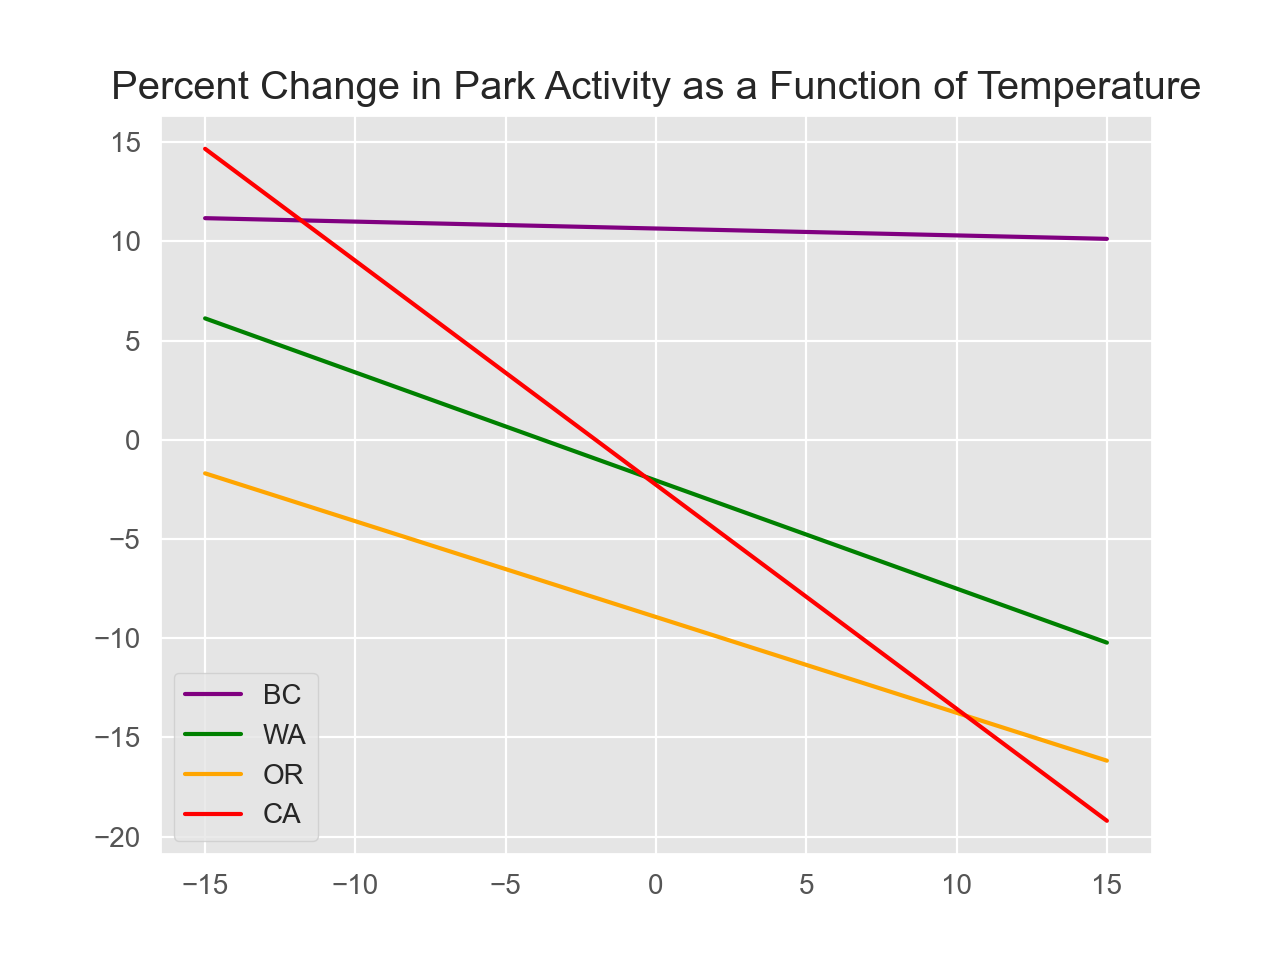

In [3094]:
fig, ax = plt.subplots()
sns.lineplot(x=x_axis, y=bc_y_axis, ax =ax, label='BC', color='purple')
sns.lineplot(x=x_axis, y=wa_y_axis, ax =ax, label='WA', color='green')
sns.lineplot(x=x_axis, y=or_y_axis, ax =ax, label='OR', color='orange')
sns.lineplot(x=x_axis, y=ca_y_axis, ax =ax, label='CA', color='red')
#plt.vlines(x=BC_temp, ymin=-2, ymax=1, colors='purple', ls=':', lw=2, label='BC mean heatwave temp')
#plt.vlines(x=WA_temp, ymin=-2, ymax=1, colors='green', ls=':', lw=2, label='WA mean heatwave temp')
#plt.vlines(x=OR_temp, ymin=-2, ymax=1, colors='orange', ls=':', lw=2, label='OR mean heatwave temp')
#plt.vlines(x=CA_temp, ymin=-2, ymax=1, colors='red', ls=':', lw=2, label='CA mean heatwave temp')

plt.title("Percent Change in Park Activity as a Function of Temperature")
#ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
#plt.legend(bbox_to_anchor=(1, 0.5))

In [2764]:
def get_average_effects(dic, response, state):
    
    #mob_vars_subset = mob_vars[mob_vars['state'] == state]
    
    estimate_subset = dic[response]
    
    global_int = estimate_subset['global_intercept']
    
    variable_sum = sum([estimate_subset['temp_diff']*mob_vars_subset['temp_diff'].mean(), 
                  estimate_subset['stage_frac']*mob_vars_subset['stage_frac'].mean(), 
                estimate_subset['weekend']*mob_vars_subset['weekend'].mean(), 
                  estimate_subset['year2021']*mob_vars_subset['2021'].mean(),
                  estimate_subset['year2022']*mob_vars_subset['2022'].mean(), 
                  estimate_subset['hw_duration']*mob_vars_subset['hw_dur'].mean(), 
                  estimate_subset['first_annual_hw']*mob_vars_subset['first_annual_hw'].mean(), 
                  estimate_subset['coast_binary']*mob_vars_subset['coast_binary'].mean() , 
                  estimate_subset['temperature_2m_winter']*mob_vars_subset['temperature_2m_winter'].mean(), 
                  estimate_subset['income_dec']*mob_vars_subset['income_dec'].mean(), 
                  estimate_subset['over65_dec']*mob_vars_subset['over65_dec'].mean()])
    
    print(global_int, variable_sum, state)
    
    if state != 'California':
    
        slope = estimate_subset[f'heat_temp_centered_{state}'] + estimate_subset[f'heat_temp_centered_California']
        final_average = global_int + variable_sum + estimate_subset[f'{state}_intercept']

    else: 
        
        slope = estimate_subset[f'heat_temp_centered_California']
        final_average = global_int + variable_sum 
        
        
    return [slope, final_average]



In [2765]:
df.columns = ['variable', 'estimate']

In [2766]:
mob_vars_subset = mob_vars[mob_vars['state'] == "California"]

In [2767]:
mob_vars['2020'] = [1 if x==2020 else 0 for x in mob_vars['year']]
mob_vars['2021'] = [1 if x==2021 else 0 for x in mob_vars['year']]
mob_vars['2022'] = [1 if x==2022 else 0 for x in mob_vars['year']]
mob_vars['hw_dur'] = [1 if x=='>5 days' else 0 for x in mob_vars['heatwave_dur']]

In [1824]:
dic = {}
for response in ['workplaces', 'residential', 'grocery_pharmacy', 'parks', 'retail', 'transit']:
    
    dic[response] = {}
    subset = df[df[response]==1].reset_index()
    dic[response]['global_intercept'] = subset.iloc[0, 2]
    dic[response]['heat_temp_centered_California'] = subset.iloc[1,2]
    dic[response]['British Columbia_intercept'] = subset.iloc[2,2]
    dic[response]['Oregon_intercept'] = subset.iloc[3,2]
    dic[response]['Washington_intercept'] = subset.iloc[4,2]
    dic[response]['heat_temp_centered_British Columbia'] = subset.iloc[5,2]
    dic[response]['heat_temp_centered_Oregon'] = subset.iloc[6,2]
    dic[response]['heat_temp_centered_Washington'] = subset.iloc[7,2]
    dic[response]['temp_diff'] = subset.iloc[8,2]
    dic[response]['stage_frac'] = subset.iloc[9,2]
    dic[response]['weekend'] = subset.iloc[10,2]
    dic[response]['year2021'] = subset.iloc[11,2]
    dic[response]['year2022'] = subset.iloc[12,2]
    dic[response]['hw_duration'] = subset.iloc[13,2]
    dic[response]['first_annual_hw'] = subset.iloc[14,2]
    dic[response]['coast_binary'] = subset.iloc[15,2]
    dic[response]['temperature_2m_winter'] = subset.iloc[16,2]
    dic[response]['income_dec'] = subset.iloc[17,2]
    dic[response]['over65_dec'] = subset.iloc[18,2]

In [1825]:
mob_vars_subset = mob_vars[mob_vars['state'] == "California"]
dic['parks']['income_dec']*mob_vars_subset['income_dec'].mean()

-4.759759594678189

In [1826]:
mob_vars_subset['coast_binary'].mean()

0.2180385288966725

In [1829]:
mob_vars_subset['income_dec'].describe()

count    2284.000000
mean        5.415499
std         2.827861
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: income_dec, dtype: float64

In [1830]:
def get_average_effects(dic, response, state):
    
    mob_vars_subset = mob_vars[mob_vars['state'] == state]
    
    estimate_subset = dic[response]
    
    global_int = estimate_subset['global_intercept']
    
    variable_sum = sum([estimate_subset['temp_diff']*mob_vars_subset['temp_diff'].mean(), 
                  estimate_subset['stage_frac']*mob_vars_subset['stage_frac'].mean(), 
                estimate_subset['weekend']*mob_vars_subset['weekend'].mean(), 
                  estimate_subset['year2021']*mob_vars_subset['2021'].mean(),
                  estimate_subset['year2022']*mob_vars_subset['2022'].mean(), 
                  estimate_subset['hw_duration']*mob_vars_subset['hw_dur'].mean(), 
                  estimate_subset['first_annual_hw']*mob_vars_subset['first_annual_hw'].mean(), 
                  estimate_subset['coast_binary']*mob_vars_subset['coast_binary'].mean() , 
                  estimate_subset['temperature_2m_winter']*mob_vars_subset['temperature_2m_winter'].mean(), 
                  estimate_subset['income_dec']*mob_vars_subset['income_dec'].mean(), 
                  estimate_subset['over65_dec']*mob_vars_subset['over65_dec'].mean()])
    
    print(global_int, variable_sum, state)
    
    if state != 'California':
    
        slope = estimate_subset[f'heat_temp_centered_{state}'] + estimate_subset[f'heat_temp_centered_California']
        final_average = global_int + variable_sum + estimate_subset[f'{state}_intercept']

    else: 
        
        slope = estimate_subset[f'heat_temp_centered_California']
        final_average = global_int + variable_sum 
        
        
    return [slope, final_average]




In [1831]:
params_dic = {}
for response in ['residential', 'parks']:
    params_dic[response] = {}
    for state in ['British Columbia', 'Washington', 'Oregon', 'California']:
        params_dic[response][state] = get_average_effects(dic, response, state)
        print(response, state, params_dic[response][state])

-0.856610417669164 -0.015471618258412145 British Columbia
residential British Columbia [-0.027261895259272098, -0.6935316654006661]
-0.856610417669164 0.019160504540601975 Washington
residential Washington [0.0524474296598739, -0.25764870416632]
-0.856610417669164 0.09194453772500097 Oregon
residential Oregon [-0.014112856610112398, -0.265794497204618]
-0.856610417669164 0.22599698760334005 California
residential California [0.0649393990629159, -0.6306134300658239]
6.56395931880157 4.611971466728722 British Columbia
parks British Columbia [-0.48141976664505604, 24.78775337467549]
6.56395931880157 4.356567876094931 Washington
parks Washington [-0.6773613270041201, 9.0900699695199]
6.56395931880157 2.8019371796656167 Oregon
parks Oregon [-0.78333180923192, 0.5598358208307168]
6.56395931880157 1.24716635127248 California
parks California [-1.07809945742498, 7.81112567007405]


In [1832]:
get_average_effects(dic, 'parks', 'California')

6.56395931880157 1.24716635127248 California


[-1.07809945742498, 7.81112567007405]

In [1833]:
x_axis = np.linspace(-10,10,20)

In [1834]:
bc_line = np.poly1d(params_dic['parks']['British Columbia'])
wa_line = np.poly1d(params_dic['parks']['Washington'])
or_line = np.poly1d(params_dic['parks']['Oregon'])
ca_line = np.poly1d(params_dic['parks']['California'])

In [1835]:
x_axis = np.linspace(-10,10,20)
bc_y_axis = bc_line(x_axis)
wa_y_axis = wa_line(x_axis)
or_y_axis = or_line(x_axis)
ca_y_axis = ca_line(x_axis)

In [1836]:
ca_y_axis

array([18.59212024, 17.45727871, 16.32243718, 15.18759564, 14.05275411,
       12.91791257, 11.78307104, 10.64822951,  9.51338797,  8.37854644,
        7.2437049 ,  6.10886337,  4.97402183,  3.8391803 ,  2.70433877,
        1.56949723,  0.4346557 , -0.70018584, -1.83502737, -2.9698689 ])

In [1837]:
plt.style.use('ggplot')
pos = ax.get_position()

In [1838]:
BC_temp = mob_vars[mob_vars['state'] == "British Columbia"]['heat_temp_centered'].mean()
WA_temp = mob_vars[mob_vars['state'] == "Washington"]['heat_temp_centered'].mean()
OR_temp = mob_vars[mob_vars['state'] == "Oregon"]['heat_temp_centered'].mean()
CA_temp = mob_vars[mob_vars['state'] == "California"]['heat_temp_centered'].mean()

Text(0.5, 1.0, 'Percent Change in Park Activity as a Function of Temperature')

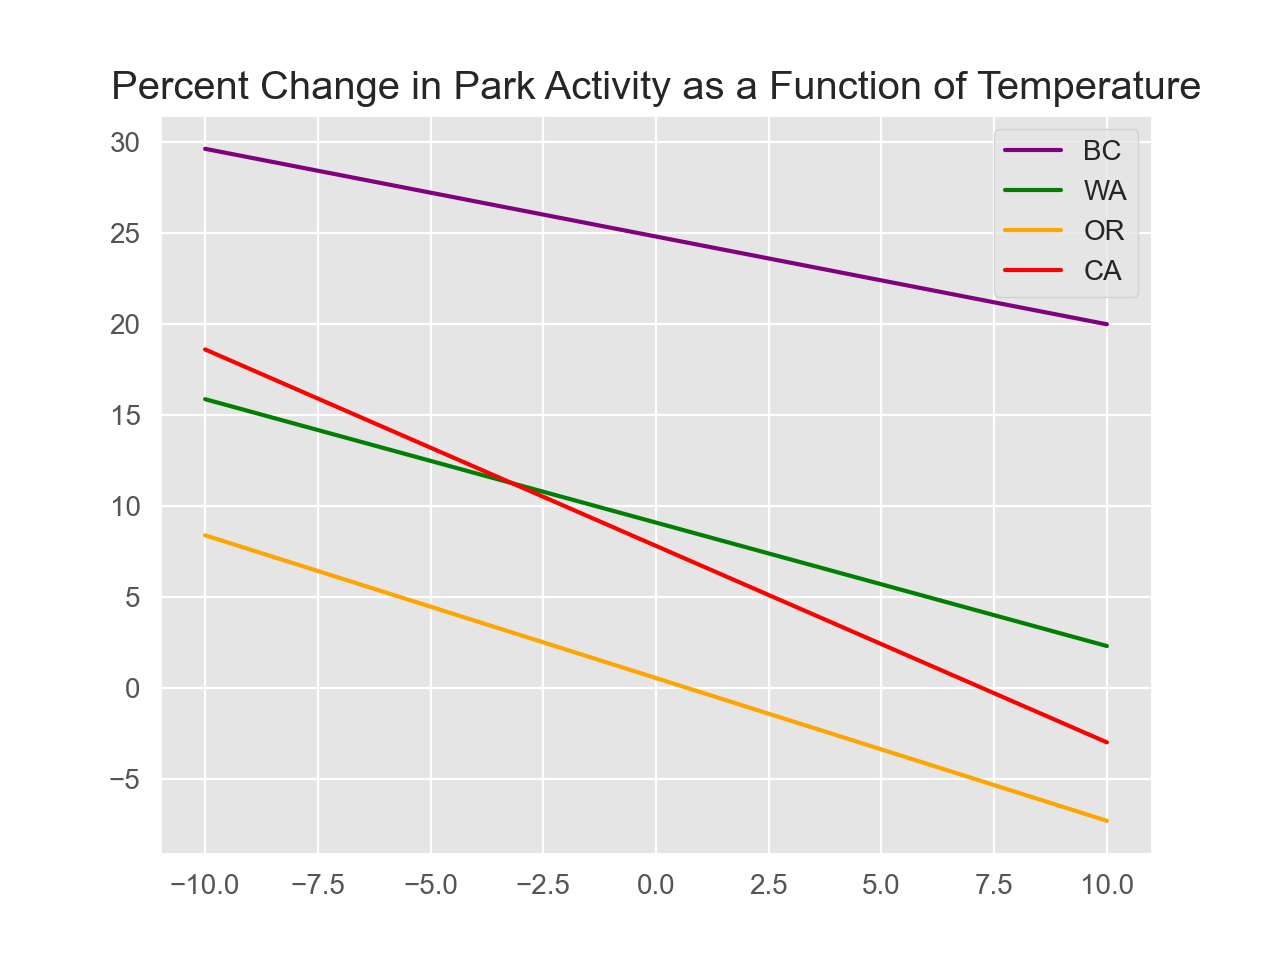

In [1839]:
fig, ax = plt.subplots()
sns.lineplot(x=x_axis, y=bc_y_axis, ax =ax, label='BC', color='purple')
sns.lineplot(x=x_axis, y=wa_y_axis, ax =ax, label='WA', color='green')
sns.lineplot(x=x_axis, y=or_y_axis, ax =ax, label='OR', color='orange')
sns.lineplot(x=x_axis, y=ca_y_axis, ax =ax, label='CA', color='red')
#plt.vlines(x=BC_temp, ymin=-2, ymax=1, colors='purple', ls=':', lw=2, label='BC mean heatwave temp')
#plt.vlines(x=WA_temp, ymin=-2, ymax=1, colors='green', ls=':', lw=2, label='WA mean heatwave temp')
#plt.vlines(x=OR_temp, ymin=-2, ymax=1, colors='orange', ls=':', lw=2, label='OR mean heatwave temp')
#plt.vlines(x=CA_temp, ymin=-2, ymax=1, colors='red', ls=':', lw=2, label='CA mean heatwave temp')

plt.title("Percent Change in Park Activity as a Function of Temperature")
#ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
#plt.legend(bbox_to_anchor=(1, 0.5))

In [1481]:
BC_average + dic['BC_intercept']

KeyError: 'BC_intercept'

In [ ]:
BC

(-5.27530945013604, -0.2907304730025854)

In [75]:
df.iloc[8, 1]*mob_vars['temp_diff'].mean() + \
df.iloc[9, 1]*mob_vars['stage_frac'].mean() + df.iloc[10, 1]*mob_vars['weekend'].mean() + df.iloc[11, 1]*mob_vars['2021'].mean() + df.iloc[12, 1]*mob_vars['2021'].mean() \
+ df.iloc[13, 1]*mob_vars['hw_dur'].mean() + df.iloc[14, 1]*mob_vars['first_annual_hw'].mean() + df.iloc[15, 1]*mob_vars['coast_binary'].mean() + df.iloc[16, 1]*mob_vars['temperature_2m_winter'].mean() \
+ df.iloc[17, 1]*mob_vars['income_dec'].mean()  + df.iloc[13, 1]*mob_vars['over65_dec'].mean()

0.5994009767020654

In [65]:
def get_state_intercept(dic, mob_vars):
    

In [52]:
BC_intercept = df.iloc[0, 1] + df.iloc[1, 1]*0 + df.iloc[2, 1] * 1 + df.iloc[5, 1] * 0 + df.iloc[8, 1]*mob_vars['temp_diff'].mean() + \
df.iloc[9, 1]*mob_vars['stage_frac'].mean() + df.iloc[10, 1]*mob_vars['weekend'].mean() + df.iloc[11, 1]*mob_vars['2021'].mean() + df.iloc[12, 1]*mob_vars['2021'].mean() \
+ df.iloc[13, 1]*mob_vars['hw_dur'].mean() + df.iloc[14, 1]*mob_vars['first_annual_hw'].mean() + df.iloc[15, 1]*mob_vars['coast_binary'].mean() + df.iloc[16, 1]*mob_vars['temperature_2m_winter'].mean() \
+ df.iloc[17, 1]*mob_vars['income_dec'].mean()  + df.iloc[13, 1]*mob_vars['over65_dec'].mean()

In [54]:
CA_intercept = df.iloc[0, 1] + df.iloc[1, 1]*0 + df.iloc[3, 1] + df.iloc[5, 1] * 0 + df.iloc[8, 1]*mob_vars['temp_diff'].mean() + \
df.iloc[9, 1]*mob_vars['stage_frac'].mean() + df.iloc[10, 1]*mob_vars['weekend'].mean() + df.iloc[11, 1]*mob_vars['2021'].mean() + df.iloc[12, 1]*mob_vars['2021'].mean() \
+ df.iloc[13, 1]*mob_vars['hw_dur'].mean() + df.iloc[14, 1]*mob_vars['first_annual_hw'].mean() + df.iloc[15, 1]*mob_vars['coast_binary'].mean() + df.iloc[16, 1]*mob_vars['temperature_2m_winter'].mean() \
+ df.iloc[17, 1]*mob_vars['income_dec'].mean()  + df.iloc[13, 1]*mob_vars['over65_dec'].mean()

In [56]:
CA_intercept

-1.4249643783805825

In [34]:
mob_vars['heatwave_dur']

0       <5 days
1       <5 days
2       <5 days
3       <5 days
4       >5 days
         ...   
6209    <5 days
6210    <5 days
6211    <5 days
6212    <5 days
6213    <5 days
Name: heatwave_dur, Length: 6214, dtype: object

In [23]:
BC_intercept

3.1411658650496674

In [14]:
equation

-0.357955492423928

In [943]:
mob_vars

,Unnamed: 0,location,first_annual_hw,heat_ID,workplaces_difference,residential_difference,grocery_pharmacy_difference,retail_difference,parks_difference,transit_difference,...,temp_diff,heat_temp_centered,coast_binary,temperature_2m_winter,income_dec,over65_dec,2020,2021,2022,hw_dur
0,0,"Alameda County, California",1,d7b448e7-084c-4bfa-a5dc-2c2f7805665b,2.0,-1.0,1.0,-1.0,-6.0,2.0,...,13.428375,-1.950484,False,6.314208,10,3,1,0,0,0
1,1,"Alameda County, California",1,d7b448e7-084c-4bfa-a5dc-2c2f7805665b,3.0,-1.0,0.0,-1.0,-3.0,1.0,...,9.585419,-2.008040,False,6.314208,10,3,1,0,0,0
2,2,"Alameda County, California",0,27329488-1855-444f-be5f-e849a8a37970,15.0,-1.0,7.0,14.0,8.0,5.0,...,3.115372,-2.898635,False,6.314208,10,3,1,0,0,0
3,3,"Alameda County, California",0,27329488-1855-444f-be5f-e849a8a37970,2.0,1.0,8.0,4.0,12.0,1.0,...,3.685379,-2.488631,False,6.314208,10,3,1,0,0,0
4,4,"Alameda County, California",0,a1ebcf14-5a2d-4c10-9539-c0a87d613f14,-1.0,0.0,1.0,0.0,-10.0,-2.0,...,8.565338,0.743211,False,6.314208,10,3,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,2213,"Thompson-Nicola, British Columbia",0,d9c7e699-b7b8-47f2-910c-9999ef7ba5e7,1.0,-1.0,-6.0,-6.0,5.0,-6.0,...,8.750839,-6.292677,False,-9.490944,6,5,0,0,1,0
2214,2214,"Thompson-Nicola, British Columbia",0,15ca0559-a0da-49fe-bea4-d949221549cf,1.0,1.0,1.0,1.0,54.0,1.0,...,11.081390,-3.962126,False,-9.490944,6,5,0,0,1,0
2215,2215,"Thompson-Nicola, British Columbia",0,15ca0559-a0da-49fe-bea4-d949221549cf,0.0,2.0,4.0,0.0,-2.0,4.0,...,13.134964,-5.270125,False,-9.490944,6,5,0,0,1,0
2216,2216,"Thompson-Nicola, British Columbia",0,41652cae-d8c2-48f9-b1ea-9109e1660e8a,-3.0,-1.0,1.0,3.0,2.0,12.0,...,13.800476,-4.604613,False,-9.490944,6,5,0,0,1,0


In [950]:
df= df.drop('Unnamed: 0', axis=1)

In [956]:
df

,x
0,-7.506034
1,-6.667594
2,-2.200262
3,-5.303983
4,-6.547992
...,...
2213,-16.535965
2214,-15.852851
2215,-4.135679
2216,-3.160349


In [957]:
df = df.merge(mob_vars, left_index=True, right_index=True)

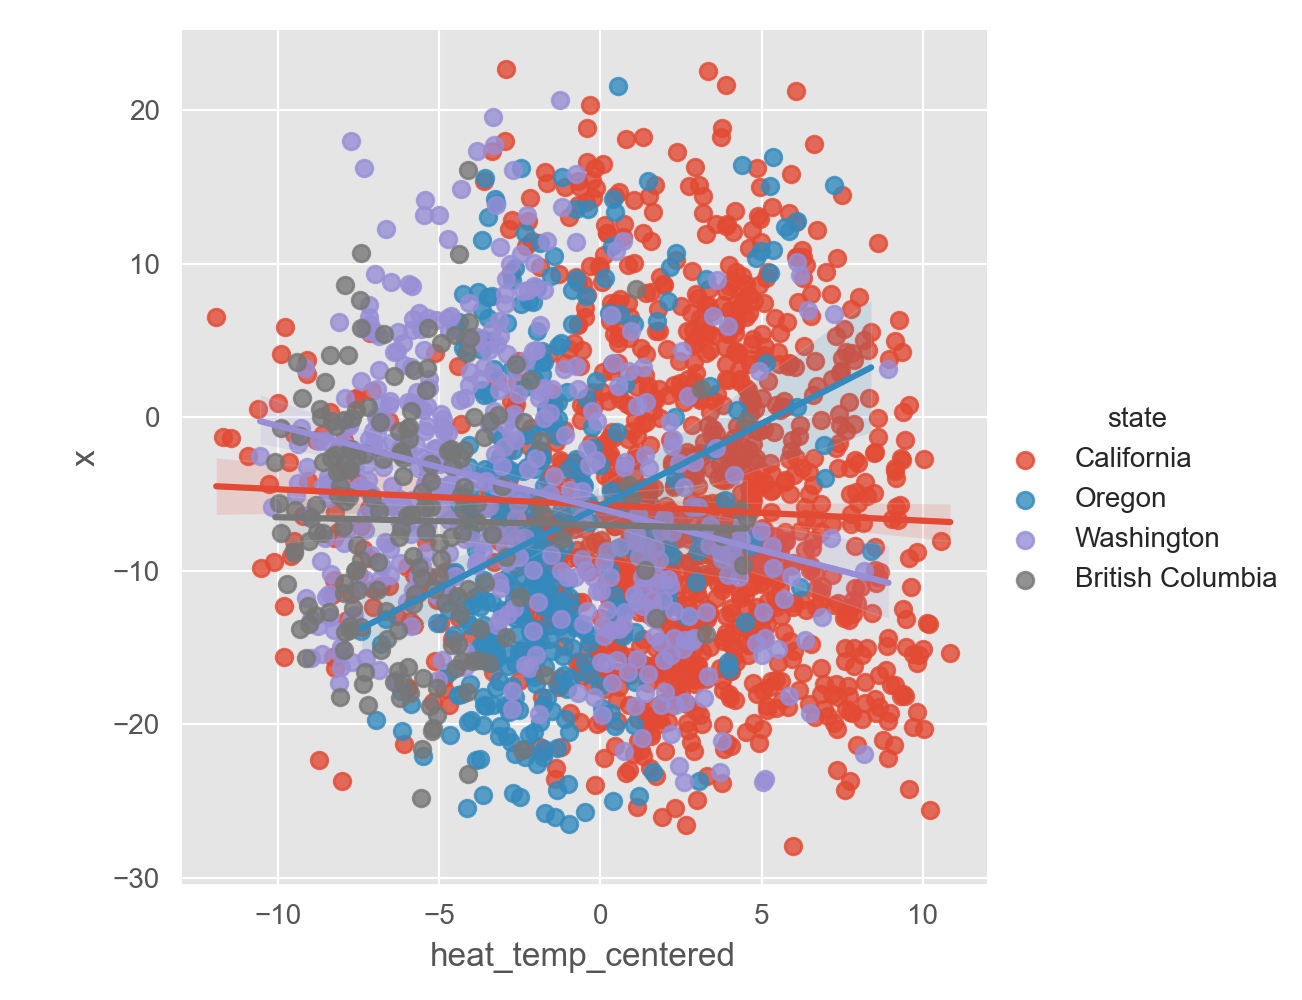

In [973]:
sns.lmplot(df, x='heat_temp_centered', y='x', hue='state')

In [ ]:
  2.06856 
 -0.30003 
 11.12601 
 -1.39251 
  0.21056 
 49.27812 
 -1.67438 
 -2.29770 
  6.43963 
 20.54952 
 -1.89966 
 -0.02975 
 12.11220 
 10.81771 
 26.67450 
 -6.58344 
 -8.61174 
  7.94193 
 43.21462 
 30.05329 
434.93313 